In [1]:
from rateslib import *
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log
from numba import jit
import numpy as np 
import pandas as pd
import warnings
import json
import os

In [2]:
@jit(nopython=True)
def single_sided_mida(b, w, t):
    sum_w = w.cumsum()
    t = sum_w[-1] if t > sum_w[-1] else t
    n = len(np.where(t > sum_w)[0])
    if n == 0:
        return b[0]
    else:
        sum_bw = (b * w).cumsum()
        p = b[0] * sum_w[0]
        for j in range(1, n):
            p += b[j] * (sum_w[j] - sum_w[j - 1])
            p += (sum_bw[j - 1] - b[j] * sum_w[j - 1]) * (log(sum_w[j]) - log(sum_w[j - 1]))
        p += b[n] * (t - sum_w[n - 1])
        p += (sum_bw[n - 1] - b[n] * sum_w[n - 1]) * (log(t) - log(sum_w[n - 1]))
        return p / t

def mean_intrinsic_depth_average(b, w, a, v, t):
    p_mbida = single_sided_mida(b, w, t)
    p_maida = single_sided_mida(a, v, t)
    return (p_mbida + p_maida) / 2

In [3]:
with open("Data/order_books/all_order_books_0319.json") as f:
    books = json.load(f)

results = []
order_books_by_symbol = {}

z1_indices = set(range(16, 18))
z2_indices = set(range(0, 3)) | set(range(30, 41))
z3_indices = set(range(18, 30))
z4_indices = set(range(3, 16))  
 
#Spread and butterfly mins applied as sum of legs 
z1 = 250 #1 month spread 
z2 = 500 #1 month/3 month butterfly 
z3 = 1000 #3 month spread
z4 = 2000 #3 month 

z_by_index = {}
for i in z1_indices: z_by_index[i] = z1
for i in z2_indices: z_by_index[i] = z2
for i in z3_indices: z_by_index[i] = z3
for i in z4_indices: z_by_index[i] = z4

for i, book in enumerate(books):
    
    z = z_by_index.get(i)

    b = np.array(book["bid_prices"], dtype=float)
    w = np.array(book["bid_sizes"], dtype=float)
    a = np.array(book["ask_prices"], dtype=float)
    v = np.array(book["ask_sizes"], dtype=float)

    # Replace sentinel prices and zero sizes with NaN
    invalid_bids = (b > 1e9) | (w <= 0)
    invalid_asks = (a > 1e9) | (v <= 0)
    b[invalid_bids] = np.nan
    w[invalid_bids] = np.nan
    a[invalid_asks] = np.nan
    v[invalid_asks] = np.nan

    # Filter valid entries
    valid_bids = ~np.isnan(b) & ~np.isnan(w)
    valid_asks = ~np.isnan(a) & ~np.isnan(v)

    b_clean = b[valid_bids]
    w_clean = w[valid_bids]
    a_clean = a[valid_asks]
    v_clean = v[valid_asks]

    if len(b_clean) > 0 and len(a_clean) > 0:
        mid_price = mean_intrinsic_depth_average(b_clean, w_clean, a_clean, v_clean, z)
    else:
        mid_price = None

    results.append({
        "Instrument": book["symbol"],
        "Mid-Price": mid_price
    })

    order_books_by_symbol[book["symbol"]] = pd.DataFrame({
        "Bid Size": w,
        "Bid Price": b,
        "Ask Price": a,
        "Ask Size": v
    })

results_df = pd.DataFrame(results)

In [4]:
order_books_by_symbol["SR3M5"]

,Bid Size,Bid Price,Ask Price,Ask Size
0,1137.0,95.890,95.895,44.0
1,1021.0,95.885,95.900,1390.0
2,1141.0,95.880,95.905,1253.0
3,864.0,95.875,95.910,1211.0
4,1360.0,95.870,95.915,1188.0
5,1280.0,95.865,95.920,1233.0
6,1185.0,95.860,95.925,1013.0
7,1243.0,95.855,95.930,1028.0
8,1205.0,95.850,95.935,1008.0
9,1156.0,95.845,95.940,1156.0


In [5]:
results_df

,Instrument,Mid-Price
0,SR1H5,95.676250
1,SR1J5,95.687500
2,SR1K5,95.735454
3,SR3H5,95.688827
4,SR3M5,95.894570
5,SR3U5,96.131807
6,SR3Z5,96.305187
7,SR3H6,96.421901
8,SR3M6,96.483327
9,SR3U6,96.505654


In [6]:
def calculate_core_prices(A, s, w=None):
   
    if w is not None:
        W = np.diag(w)
        p_star = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ s)
    else:
        p_star = np.linalg.pinv(A) @ s
    return p_star

A = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1],
              [0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1]])
s = []

for _, row in results_df.iterrows():
    price = row["Mid-Price"]
    if isinstance(price, float):
        if "-" in row["Instrument"]:
            price = price * 0.01  # If instrument is a spread, convert from ticks to price
        s.append(price)

s = np.array(s)

assert np.linalg.matrix_rank(A) == A.shape[1] #Check for full column rank

core_prices = calculate_core_prices(A, s, w = [1.0] * 16 + [0.2] * 2 + [0.5] * 12 + [0.2] * 11)

print("Core Implied Prices:", core_prices)

Core Implied Prices: [95.67573644 95.68795219 95.73551496 95.6892988  95.89458857 96.13004098
 96.30639685 96.422075   96.48434697 96.50377852 96.49477681 96.47232754
 96.44241395 96.41121787 96.37800358 96.34179284]


In [7]:
core_rates = 100 - core_prices
print("Core Implied Rates:", core_rates)

Core Implied Rates: [4.32426356 4.31204781 4.26448504 4.3107012  4.10541143 3.86995902
 3.69360315 3.577925   3.51565303 3.49622148 3.50522319 3.52767246
 3.55758605 3.58878213 3.62199642 3.65820716]


In [8]:
core_rates_df = pd.DataFrame({
    "Rate": np.round(core_rates, 6)
})
print(core_rates_df)

        Rate
0   4.324264
1   4.312048
2   4.264485
3   4.310701
4   4.105411
5   3.869959
6   3.693603
7   3.577925
8   3.515653
9   3.496221
10  3.505223
11  3.527672
12  3.557586
13  3.588782
14  3.621996
15  3.658207


In [9]:
curve_sofr = Curve(
    nodes={
        dt(2025, 3, 19): 1.0,
        dt(2025, 4, 1): 1.0,
        dt(2025, 5, 1): 1.0,
        dt(2025, 6, 1): 1.0,
        dt(2025, 6, 18): 1.0,
        dt(2025, 9, 17): 1.0,
        dt(2025, 12, 17): 1.0,
        dt(2026, 3, 18): 1.0,
        dt(2026, 6, 17): 1.0,
        dt(2026, 9, 16): 1.0,
        dt(2026, 12, 16): 1.0,
        dt(2027, 3, 17): 1.0,
        dt(2027, 6, 16): 1.0,
        dt(2027, 9, 15): 1.0,
        dt(2027, 12, 15): 1.0,
        dt(2028, 3, 15): 1.0,
        dt(2028, 6, 21): 1.0,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="sofr",
)

In [10]:
sofr_1903 = pd.DataFrame(
    data=[4.33, 4.33, 4.34, 4.35, 4.34, 4.33, 4.32, 4.31, 4.3, 4.3, 4.32, 4.31],
    index=pd.Index(["03-03-2025", "04-03-2025", "05-03-2025", "06-03-2025", "07-03-2025", "10-03-2025", "11-03-2025", "12-03-2025", "13-03-2025",
                    "14-03-2025", "17-03-2025", "18-03-2025"], name="reference_date"),
    columns=["rate"]
)

In [11]:
sofr_1903.to_csv("sofr_1903.csv")

In [12]:
defaults.fixings.directory = os.getcwd()

In [13]:
defaults.fixings["sofr_1903"]

reference_date
2025-03-03    4.33
2025-03-04    4.33
2025-03-05    4.34
2025-03-06    4.35
2025-03-07    4.34
2025-03-10    4.33
2025-03-11    4.32
2025-03-12    4.31
2025-03-13    4.30
2025-03-14    4.30
2025-03-17    4.32
2025-03-18    4.31
Name: rate, dtype: float64

In [14]:
args_1m = dict(spec="usd_stir1", curves="sofr")
args_3m = dict(spec="usd_stir", curves="sofr")
sofr_futures = [
    STIRFuture(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_1903"], **args_1m),
    STIRFuture(dt(2025, 4, 1), dt(2025, 5, 1), **args_1m),
    STIRFuture(dt(2025, 5, 1), dt(2025, 6, 1), **args_1m),
    STIRFuture(effective=get_imm(code="H25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H28"), termination="3m", **args_3m),
]

In [15]:
defaults.spec["usd_stir"]

{'frequency': 'q',
 'roll': 'imm',
 'eom': False,
 'modifier': 'mf',
 'calendar': 'nyc',
 'payment_lag': 0,
 'currency': 'usd',
 'convention': 'act360',
 'leg2_spread_compound_method': 'none_simple',
 'leg2_fixing_method': 'rfr_payment_delay',
 'leg2_method_param': 0,
 'bp_value': 25.0,
 'nominal': 1000000.0}

In [16]:
defaults.spec["usd_stir1"]

{'frequency': 'm',
 'roll': 'som',
 'eom': False,
 'modifier': 'mf',
 'calendar': 'nyc',
 'payment_lag': 0,
 'currency': 'usd',
 'convention': 'act360',
 'leg2_spread_compound_method': 'none_simple',
 'leg2_fixing_method': 'rfr_payment_delay_avg',
 'leg2_method_param': 0,
 'bp_value': 41.67,
 'nominal': 5000000.0}

In [17]:
s_sofr =  core_rates_df["Rate"].tolist()

In [18]:
instrument_labels_sofr = ["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8"]

In [19]:
solver_sofr = Solver(
    curves=[curve_sofr],
    instruments=sofr_futures,
    s=s_sofr,
    instrument_labels=instrument_labels_sofr,
    id="sofr",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.20061717463139e-14, `time`: 0.8580s


In [20]:
for inst in sofr_futures:
    print(inst.rate(solver=solver_sofr).real)

4.324264000019553
4.31204800001943
4.26448500002255
4.31070094196003
4.10541094286395
3.869958944631851
3.6936029472172067
3.5779249505491397
3.5156529545489694
3.4962209591316356
3.505222964208559
3.5276719696888588
3.557585975481564
3.5887819814964694
3.621995987644526
3.6582069933699715


In [21]:
m5 = STIRFuture(effective=get_imm(code="M25"), termination="3m", **args_3m)

In [22]:
m5.rate(solver=solver_sofr)

<Dual: 4.105411, (sofr0, sofr1, sofr2, ...), [0.0, 0.0, 0.0, ...]>

In [23]:
m5.rate(curve_sofr)

<Dual: 4.105411, (sofr0, sofr1, sofr2, ...), [0.0, 0.0, 0.0, ...]>

In [24]:
j5_1 = STIRFuture(dt(2025, 4, 1), dt(2025, 5, 1), **args_1m)

In [25]:
j5_1.rate(solver=solver_sofr)

<Dual: 4.312048, (sofr0, sofr1, sofr2, ...), [0.0, 1202.2, -1206.5, ...]>

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x25c7fde2ef0>])

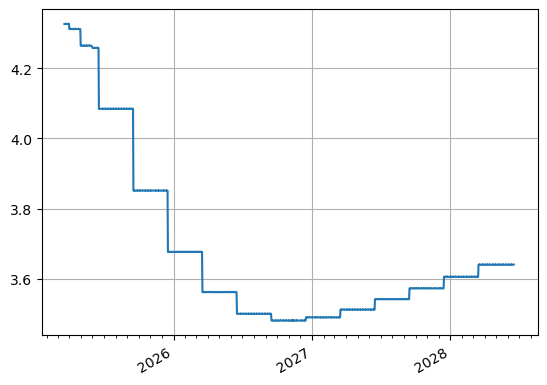

In [26]:
curve_sofr.plot("1b")

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x25c7ff6d990>])

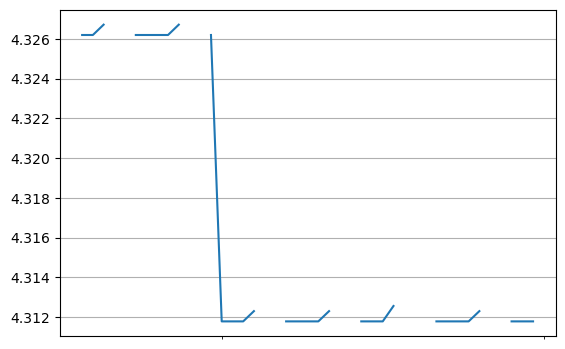

In [27]:
curve_sofr.plot("1b", right=dt(2025, 4, 30))

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x25c0003e860>])

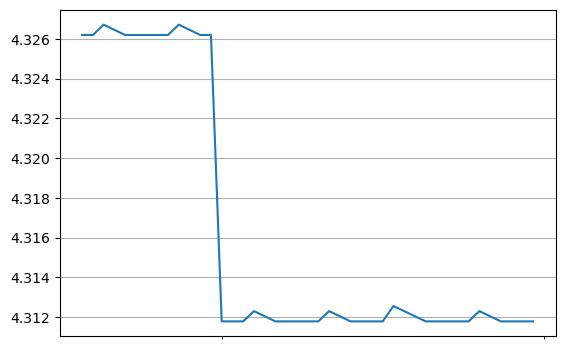

In [28]:
curve_sofr.plot("1d", right=dt(2025, 4, 30))

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x25c000a77c0>])

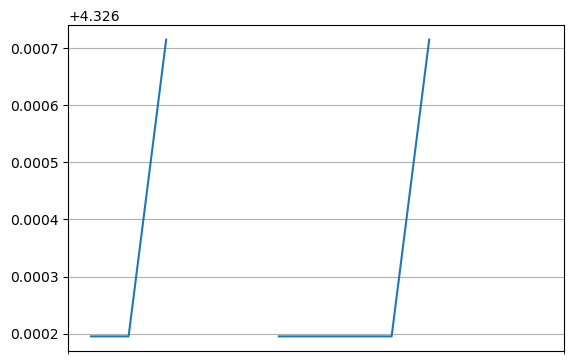

In [29]:
curve_sofr.plot("1b", right=dt(2025, 3, 31))

In [30]:
curve_sofr.rate(dt(2025, 3, 21), dt(2025, 3, 22)).real

4.326195119102039

In [31]:
nyc_cal = NamedCal("nyc")

In [32]:
nyc_cal.is_bus_day(dt(2025, 3, 22))

False

In [33]:
curve_sofr.rate(dt(2025, 3, 21), dt(2025, 3, 24)).real

4.326715027815453

In [34]:
daycount = dcf(dt(2025, 3, 21), dt(2025, 3, 24), "act360")
print(daycount)

0.008333333333333333


In [35]:
start_df = curve_sofr[dt(2025, 3, 21)].real
print(start_df)

0.9997596991437674


In [36]:
end_df = curve_sofr[dt(2025, 3, 24)].real
print(end_df)

0.9993993561260223


In [37]:
def rate_simple(start_df, end_df, daycount):
    return (start_df/end_df-1)*(1/daycount)*100

In [38]:
rate_simple(start_df, end_df, daycount)

4.326715027818118

In [39]:
for date in nyc_cal.cal_date_range(dt(2025, 3, 19), dt(2025, 3, 26)):
    print(curve_sofr[date].real)

1.0
0.9998798423529536
0.9997596991437674
0.9996395703707064
0.9995194560320362
0.9993993561260223
0.9992792706509305
0.9991591996050269


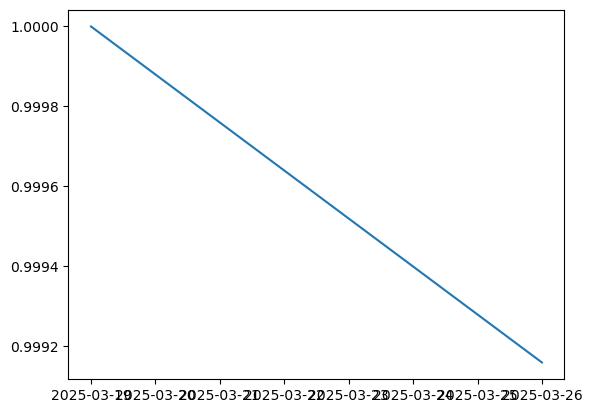

In [40]:
fig, ax = plt.subplots(1, 1)
x, y1 = [], []
for date in nyc_cal.cal_date_range(dt(2025, 3, 19), dt(2025, 3, 26)):
    x.append(date)
    y1.append(curve_sofr[date])
ax.plot(x, y1)

In [41]:
curve_irs = Curve(
     nodes={
        dt(2025, 3, 19): 1.00,  # today's DF
        dt(2025, 3, 31): 1.00, #turn 1
        dt(2025, 4, 1): 1.00, #turn 1
        dt(2025, 5, 8): 1.00,  # defined effective FOMC dates..
        dt(2025, 6, 20): 1.00,
        dt(2025, 6, 30): 1.00, #turn 2
        dt(2025, 7, 1): 1.00, #turn 2
        dt(2025, 7, 31): 1.00,
        dt(2025, 9, 18): 1.00,
        dt(2025, 9, 30): 1.00, #turn 3
        dt(2025, 10, 1): 1.00, #turn 3
        dt(2025, 10, 30): 1.00,
        dt(2025, 12, 11): 1.00,
        dt(2025, 12, 31): 1.00, #turn 4
        dt(2026, 1, 2): 1.00, #turn 4
        dt(2026, 1, 29): 1.00,
        dt(2026, 3, 19): 1.00,
        dt(2026, 3, 31): 1.00, #turn 5
        dt(2026, 4, 1): 1.00, #turn 5
        dt(2026, 4, 30): 1.00,  
        dt(2026, 6, 18): 1.00,
        dt(2026, 6, 30): 1.00, #turn 6
        dt(2026, 7, 1): 1.00, #turn 6
        dt(2026, 7, 30): 1.00,
        dt(2026, 9, 17): 1.00,
        dt(2026, 9, 30): 1.00, #turn 7
        dt(2026, 10, 1): 1.00, #turn 7
        dt(2026, 10, 29): 1.00,
        dt(2026, 12, 10): 1.00,
        dt(2026, 12, 31): 1.00, #turn 8
        dt(2027, 1, 4): 1.00, #turn 8
        dt(2027, 1, 28): 1.00,
        dt(2027, 3, 18): 1.00, # estimated effective FOMC dates...
        dt(2027, 3, 31): 1.00, #turn 9
        dt(2027, 4, 1): 1.00, #turn 9
        dt(2027, 5, 6): 1.00,  
        dt(2027, 6, 17): 1.00,
        dt(2027, 6, 30): 1.00, #turn 10
        dt(2027, 7, 1): 1.00, #turn 10
        dt(2027, 7, 29): 1.00,
        dt(2027, 9, 16): 1.00,
        dt(2027, 9, 30): 1.00, #turn 11
        dt(2027, 10, 1): 1.00, #turn 11
        dt(2027, 11, 5): 1.00,
        dt(2027, 12, 16): 1.00,
        dt(2027, 12, 31): 1.00, #turn 12
        dt(2028, 1, 3): 1.00, #turn 12
        dt(2028, 1, 27): 1.00,
        dt(2028, 3, 9): 1.00,
        dt(2028, 3, 31): 1.00, #turn 13
        dt(2028, 4, 3): 1.00, #turn 13
        dt(2028, 4, 20): 1.00,
        dt(2028, 6, 21): 1.00,  # final IMM.
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [42]:
args_turn = dict(termination="1d", frequency="A", curves="irs")
args_fomc = dict(spec="usd_irs", curves="irs")
fomc_1 = IRS(dt(2025, 5, 8), dt(2025, 6, 20), **args_fomc)
fomc_2 = IRS(dt(2025, 6, 20), dt(2025, 7, 31), **args_fomc)
fomc_3 = IRS(dt(2025, 7, 31), dt(2025, 9, 18), **args_fomc)
fomc_4 = IRS(dt(2025, 9, 18), dt(2025, 10, 30), **args_fomc)
fomc_5 = IRS(dt(2025, 10, 30), dt(2025, 12, 11), **args_fomc)
fomc_6 = IRS(dt(2025, 12, 11), dt(2026, 1, 29), **args_fomc)
fomc_7 = IRS(dt(2026, 1, 29), dt(2026, 3, 19), **args_fomc)
fomc_8 = IRS(dt(2026, 3, 19), dt(2026, 4, 30), **args_fomc)
fomc_9 = IRS(dt(2026, 4, 30), dt(2026, 6, 18), **args_fomc)
fomc_10 = IRS(dt(2026, 6, 18), dt(2026, 7, 30), **args_fomc)
fomc_11 = IRS(dt(2026, 7, 30), dt(2026, 9, 17), **args_fomc)
fomc_12 = IRS(dt(2026, 9, 17), dt(2026, 10, 29), **args_fomc)
fomc_13 = IRS(dt(2026, 10, 29), dt(2026, 12, 10), **args_fomc)
fomc_14 = IRS(dt(2026, 12, 10), dt(2027, 1, 28), **args_fomc)
fomc_15 = IRS(dt(2027, 1, 28), dt(2027, 3, 18), **args_fomc)
fomc_16 = IRS(dt(2027, 3, 18), dt(2027, 5, 6), **args_fomc)
fomc_17 = IRS(dt(2027, 5, 6), dt(2027, 6, 17), **args_fomc)
fomc_18 = IRS(dt(2027, 6, 17), dt(2027, 7, 29), **args_fomc)
fomc_19 = IRS(dt(2027, 7, 29), dt(2027, 9, 16), **args_fomc)
fomc_20 = IRS(dt(2027, 9, 16), dt(2027, 11, 5), **args_fomc)
fomc_21 = IRS(dt(2027, 11, 5), dt(2027, 12, 16), **args_fomc)
fomc_22 = IRS(dt(2027, 12, 16), dt(2028, 1, 27), **args_fomc)
fomc_23 = IRS(dt(2028, 1, 27), dt(2028, 3, 9), **args_fomc)
fomc_24 = IRS(dt(2028, 3, 9), dt(2028, 4, 20), **args_fomc)
fomc_25 = IRS(dt(2028, 4, 20), dt(2028, 6, 21), **args_fomc)
turn_1a = IRS(effective=dt(2025, 3, 30), **args_turn)
turn_1b = IRS(effective=dt(2025, 3, 31), **args_turn)
turn_1c = IRS(effective=dt(2025, 4, 1), **args_turn)
turn_2a = IRS(effective=dt(2025, 6, 29), **args_turn)
turn_2b = IRS(effective=dt(2025, 6, 30), **args_turn)
turn_2c = IRS(effective=dt(2025, 7, 1), **args_turn)
turn_3a = IRS(effective=dt(2025, 9, 29), **args_turn)
turn_3b = IRS(effective=dt(2025, 9, 30), **args_turn)
turn_3c = IRS(effective=dt(2025, 10, 1), **args_turn)
turn_4a = IRS(effective=dt(2025, 12, 30), **args_turn)
turn_4b = IRS(effective=dt(2025, 12, 31), **args_turn)
turn_4c = IRS(effective=dt(2026, 1, 2), **args_turn)
turn_5a = IRS(effective=dt(2026, 3, 30), **args_turn)
turn_5b = IRS(effective=dt(2026, 3, 31), **args_turn)
turn_5c = IRS(effective=dt(2026, 4, 1), **args_turn)
turn_6a = IRS(effective=dt(2026, 6, 29), **args_turn)
turn_6b = IRS(effective=dt(2026, 6, 30), **args_turn)
turn_6c = IRS(effective=dt(2026, 7, 1), **args_turn)
turn_7a = IRS(effective=dt(2026, 9, 29), **args_turn)
turn_7b = IRS(effective=dt(2026, 9, 30), **args_turn)
turn_7c = IRS(effective=dt(2026, 10, 1), **args_turn)
turn_8a = IRS(effective=dt(2026, 12, 30), **args_turn)
turn_8b = IRS(effective=dt(2026, 12, 31), **args_turn)
turn_8c = IRS(effective=dt(2027, 1, 4), **args_turn)
turn_9a = IRS(effective=dt(2027, 3, 30), **args_turn)
turn_9b = IRS(effective=dt(2027, 3, 31), **args_turn)
turn_9c = IRS(effective=dt(2027, 4, 1), **args_turn)
turn_10a = IRS(effective=dt(2027, 6, 29), **args_turn)
turn_10b = IRS(effective=dt(2027, 6, 30), **args_turn)
turn_10c = IRS(effective=dt(2027, 7, 1), **args_turn)
turn_11a = IRS(effective=dt(2027, 9, 29), **args_turn)
turn_11b = IRS(effective=dt(2027, 9, 30), **args_turn)
turn_11c = IRS(effective=dt(2027, 10, 1), **args_turn)
turn_12a = IRS(effective=dt(2027, 12, 30), **args_turn)
turn_12b = IRS(effective=dt(2027, 12, 31), **args_turn)
turn_12c = IRS(effective=dt(2028, 1, 3), **args_turn)
turn_13a = IRS(effective=dt(2028, 3, 30), **args_turn)
turn_13b = IRS(effective=dt(2028, 3, 31), **args_turn)
turn_13c = IRS(effective=dt(2028, 4, 3), **args_turn)

In [43]:
args_irs = dict(spec="usd_irs", curves="irs")
instruments_irs = [
    IRS(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_1903"], **args_irs),
    IRS(dt(2025, 4, 1), dt(2025, 5, 1), **args_irs),
    IRS(dt(2025, 5, 1), dt(2025, 6, 1), **args_irs),
    IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs),
    Spread(turn_1a, turn_1b),
    Spread(turn_1b, turn_1c),
    Spread(turn_2a, turn_2b),
    Spread(turn_2b, turn_2c), 
    Spread(turn_3a, turn_3b),
    Spread(turn_3b, turn_3c),
    Spread(turn_4a, turn_4b),
    Spread(turn_4b, turn_4c),
    Spread(turn_5a, turn_5b),
    Spread(turn_5b, turn_5c),
    Spread(turn_6a, turn_6b),
    Spread(turn_6b, turn_6c),
    Spread(turn_7a, turn_7b),
    Spread(turn_7b, turn_7c), 
    Spread(turn_8a, turn_8b), 
    Spread(turn_8b, turn_8c),
    Spread(turn_9a, turn_9b),
    Spread(turn_9b, turn_9c),
    Spread(turn_10a, turn_10b), 
    Spread(turn_10b, turn_10c), 
    Spread(turn_11a, turn_11b),
    Spread(turn_11b, turn_11c),
    Spread(turn_12a, turn_12b),
    Spread(turn_12b, turn_12c), 
    Spread(turn_13a, turn_13b), 
    Spread(turn_13b, turn_13c),
    Fly(fomc_1, fomc_2, fomc_3),
    Fly(fomc_3, fomc_4, fomc_5),
    Fly(fomc_5, fomc_6, fomc_7),
    Fly(fomc_7, fomc_8, fomc_9),
    Fly(fomc_9, fomc_10, fomc_11),
    Fly(fomc_11, fomc_12, fomc_13),
    Fly(fomc_13, fomc_14, fomc_15),
    Fly(fomc_15, fomc_16, fomc_17),
    Fly(fomc_17, fomc_18, fomc_19),
    Fly(fomc_19, fomc_20, fomc_21),
    Fly(fomc_21, fomc_22, fomc_23),
    Fly(fomc_23, fomc_24, fomc_25),
]

In [44]:
convx_adj = [0, -0.00007, -0.00036, 0, -0.00199, -0.00533, -0.00994, -0.01582, -0.02291, -0.03121, -0.04068, -0.05129, -0.06302, -0.07583, -0.08971, 
             -0.10575]
s_adj = [
 inst.rate(solver=solver_sofr, curves="sofr").real + convx_adj for (inst,convx_adj) in zip(instruments_irs[:16], convx_adj)
]
print(s_adj)

[4.3313282725389675, 4.319216403107014, 4.2716791395612015, 4.310700941960031, 4.103420942863949, 3.864628944631851, 3.6836629472172073, 3.5621049505491382, 3.4927429545489708, 3.4650109591316354, 3.46454296420856, 3.476381969688859, 3.494565975481564, 3.512951981496469, 3.532285987644526, 3.552456993369971]


In [45]:
s_irs = s_adj + [5, -5] * 13 + [0] * 12

In [46]:
weights_irs = [1] * 16 + [1e-09] * 2 + [1] * 24 + [1e-09] * 12 #Includes low weighting for first turn to favor mkt instruments 

In [47]:
instrument_labels_irs = [
    "1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8", "turn1_left", "turn1_right", 
    "turn2_left", "turn2_right", "turn3_left", "turn3_right", "turn4_left", "turn4_right", "turn5_left", "turn5_right", "turn6_left", 
    "turn6_right", "turn7_left", "turn7_right", "turn8_left", "turn8_right", "turn9_left", "turn9_right", "turn10_left", "turn10_right",
    "turn11_left", "turn11_right", "turn12_left", "turn12_right", "turn13_left", "turn13_right", "cv1", "cv2", "cv3", "cv4", "cv5", "cv6", 
    "cv7", "cv8", "cv9", "cv10", "cv11", "cv12",
]

In [48]:
solver_irs = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_irs],
    instruments=instruments_irs,
    s=s_irs,
    weights=weights_irs,
    instrument_labels=instrument_labels_irs,
    func_tol=1e-08,  
    conv_tol=1e-10,
    id="irs",
)

SUCCESS: `conv_tol` reached after 13 iterations (levenberg_marquardt), `f_val`: 1.439400739248631e-06, `time`: 0.7569s


In [49]:
for inst in instruments_irs:
    print(inst.rate(solver=solver_irs).real)

4.331640462590985
4.319491276344856
4.2722441624098995
4.309728073611423
4.103420942862944
3.864628944630668
3.6836629472162645
3.5621049505477997
3.492742954548048
3.4650109591306295
3.4645429642071117
3.476381969688831
3.4945659754790968
3.5129519814974235
3.5322859876419734
3.5524569933693413
4.449308994036727
-5.596581865940919
4.999999999633076
-4.999999999632987
4.999999999632987
-5.000000000432392
5.000000000432436
-5.000000000432436
5.000000000432303
-4.999999999633031
5.000000000432481
-4.99999999883376
5.000000000432436
-5.000000001231708
4.999999999632898
-4.999999998833626
5.000000000432303
-4.999999999633076
5.000000001231886
-5.000000000432481
5.000000000432525
-5.0000000004323475
4.999999999633031
-4.99999999963312
5.000000000432481
-4.999999999633209
-3.603153331255271e-08
6.493028337217766e-08
-1.548285499808344e-07
2.869430915097837e-07
-4.593713853751069e-07
3.0573095166630537e-07
3.232083045645595e-07
-2.0722795923688864e-06
3.6014403015371954e-06
-5.876083308820057

In [50]:
with pd.option_context('display.max_rows', None):
    print(solver_irs.error)

sofr  1H5             1.955236e-09
      1J5             1.942979e-09
      1K5             2.254996e-09
      H5             -5.803997e-06
      M5             -5.713605e-06
      U5             -5.536815e-06
      Z5             -5.278279e-06
      H6             -4.945086e-06
      M6             -4.545103e-06
      U6             -4.086836e-06
      Z6             -3.579144e-06
      H7             -3.031114e-06
      M7             -2.451844e-06
      U7             -1.850353e-06
      Z7             -1.235547e-06
      H8             -6.630029e-07
irs   1H5             3.121901e-02
      1J5             2.748732e-02
      1K5             5.650228e-02
      H5             -9.728683e-02
      M5             -1.005418e-10
      U5             -1.183054e-10
      Z5             -9.428014e-11
      H6             -1.338485e-10
      M6             -9.228174e-11
      U6             -1.005862e-10
      Z6             -1.448175e-10
      H7             -2.797762e-12
      M7            

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x25c7da52110>])

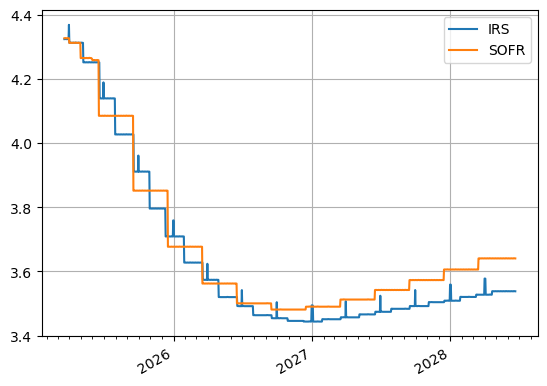

In [51]:
curve_irs.plot("1d", comparators=[curve_sofr], labels=["IRS", "SOFR"])

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x25c7da91420>])

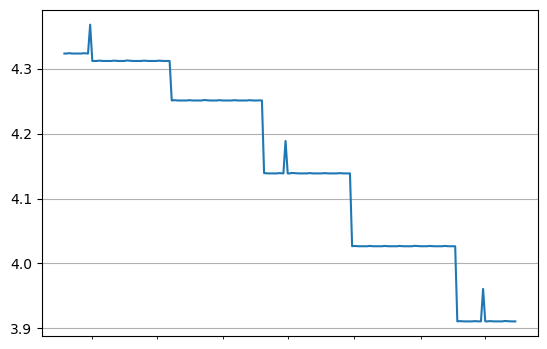

In [52]:
curve_irs.plot("1d", left=dt(2025, 3, 19), right=dt(2025, 10, 15))

In [53]:
irs_m5 = IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs)

In [54]:
irs_m5.rate(solver=solver_irs)

<Dual: 4.103421, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>

In [55]:
irs_2y = IRS(dt(2025, 3, 21), "2Y", **args_irs)

In [56]:
irs_2y.rate(solver=solver_irs)

<Dual: 3.798032, (irs0, irs1, irs2, ...), [43.5, 8.7, 0.0, ...]>

In [57]:
m5.rate(solver=solver_irs)

<Dual: 4.105411, (sofr0, sofr1, sofr2, ...), [0.0, 0.0, 0.0, ...]>

In [58]:
irs_2y.npv(solver=solver_irs)

<Dual: 0.000000, (irs0, irs1, irs2, ...), [832967.8, 166833.8, 0.0, ...]>

In [59]:
irs_2y.cashflows(curves=curve_irs)

Type   Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod  Regular  USD 2025-03-21 2026-03-23 2026-03-25     act360   
     1  FixedPeriod  Regular  USD 2026-03-23 2027-03-22 2027-03-24     act360   
leg2 0  FloatPeriod  Regular  USD 2025-03-21 2026-03-23 2026-03-25     act360   
     1  FloatPeriod  Regular  USD 2026-03-23 2027-03-22 2027-03-24     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg1 0  1.019444  1000000.0  0.959982       None  3.798032     NaN   
     1  1.011111  1000000.0  0.926807       None  3.798032     NaN   
leg2 0  1.019444 -1000000.0  0.959982       None  4.044263     0.0   
     1  1.011111 -1000000.0  0.926807       None  3.540886     0.0   

            Cashflow           NPV  FX Rate       NPV Ccy  
leg1 0 -38718.828853 -37169.389400      1.0 -37169.389400  
     1 -38402.326164 -35591.533273      1.0 -35591.533273  
leg2 0  41229.013757  39579.122415      1.0  39579.122415  
     1  35802.287765  33181.800258      1.0  33181.800258

In [60]:
irs_2y.cashflows_table(curves=curve_irs)

local_ccy,USD
collateral_ccy,NaN
payment,
2026-03-25,2510.184904
2027-03-24,-2600.038399


In [61]:
defaults.spec["usd_irs"]

{'frequency': 'a',
 'stub': 'shortfront',
 'eom': False,
 'modifier': 'mf',
 'calendar': 'nyc',
 'payment_lag': 2,
 'currency': 'usd',
 'convention': 'act360',
 'leg2_spread_compound_method': 'none_simple',
 'leg2_fixing_method': 'rfr_payment_delay',
 'leg2_method_param': 0}

In [66]:
irs_2y.analytic_delta(curve_irs)

<Dual: 191.575315, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>

In [63]:
irs_m5.delta(solver=solver_irs).style.format("{:,.2f}")

In [64]:
m5.delta(solver=solver_irs).style.format("{:,.2f}")

In [67]:
curve_full = Curve(
    nodes={
        dt(2025, 3, 19): 1.0,
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.0,
        dt(2025, 12, 17): 1.0,
        dt(2026, 3, 18): 1.0,
        dt(2026, 6, 17): 1.0,
        dt(2026, 9, 16): 1.0,
        dt(2026, 12, 16): 1.0,
        dt(2027, 3, 17): 1.0,
        dt(2027, 6, 16): 1.0,
        dt(2027, 9, 15): 1.0,
        dt(2027, 12, 15): 1.0,
        dt(2028, 3, 15): 1.0,
        dt(2028, 6, 21): 1.0,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [68]:
instruments_full = [
    Spread(sofr_futures[3], IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[4], IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[5], IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[6], IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[7], IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[8], IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[9], IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[10], IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[11], IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[12], IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[13], IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[14], IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[15], IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs)),
]

In [69]:
"""
This method does not give the proper instrument rate for equivalent 1-month IRS due to pricing as a spread off of the arithmetic average 1-month 
futures rate. 
"""
s_full = [adj *100 for adj in convx_adj[3:]] 
print(s_full)

[0, -0.199, -0.5329999999999999, -0.9939999999999999, -1.582, -2.291, -3.121, -4.0680000000000005, -5.1290000000000004, -6.3020000000000005, -7.582999999999999, -8.971, -10.575]


In [70]:
instrument_labels_full = [
    "IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8",
]

In [71]:
solver_full = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_full],
    instruments=instruments_full,
    s=s_full,
    instrument_labels=instrument_labels_full,
    id="full",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 7.053820508208589e-22, `time`: 0.7767s


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x25c020ec9d0>])

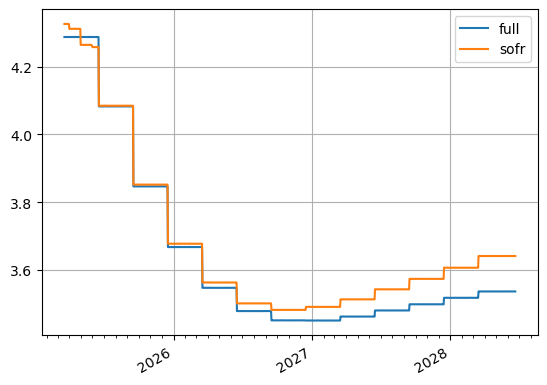

In [72]:
curve_full.plot("1d", comparators=[curve_sofr], labels=["full", "sofr"]) 

In [73]:
m5.delta(solver=solver_full).style.format("{:,.2f}")

In [74]:
m5_imm = IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", spec="usd_irs", curves="irs")

In [75]:
m5_imm.delta(solver=solver_full).style.format("{:,.2f}")

In [76]:
sep_turn = IRS(effective=dt(2025, 9, 30), termination="1d", frequency="A", curves="irs", notional=-1e9)

In [77]:
sep_turn.fixings_table(curves=curve_full, solver=solver_full).style.format("{:,.2f}")

In [78]:
pf_full = Portfolio([m5, m5_imm])

In [79]:
pf_full.delta(solver=solver_full).style.format("{:,.2f}")

In [80]:
pf_full.gamma(solver=solver_full).sum().sum()

-0.0100109002878508

In [81]:
pf_full.gamma(solver=solver_full).style.format("{:,.5f}")

In [82]:
curve_fwd = Curve(
     nodes={
        dt(2025, 3, 19): 1.00,  
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.00,
        dt(2025, 12, 17): 1.00,
        dt(2026, 3, 18): 1.00, 
        dt(2026, 6, 17): 1.00,
        dt(2026, 9, 16): 1.00,
        dt(2026, 12, 16): 1.00,
        dt(2027, 3, 17): 1.00,  
        dt(2027, 6, 16): 1.00,
        dt(2027, 9, 15): 1.00,
        dt(2027, 12, 15): 1.00,
        dt(2028, 3, 15): 1.00,
        dt(2028, 6, 21): 1.00,  
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [83]:
instruments_fwd = instruments_irs[3:16]

In [84]:
s_fwd = [
 instrument.rate(solver=solver_irs).real for (instrument) in (instruments_fwd)
]

In [85]:
solver_fwd = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_fwd],
    instruments=instruments_fwd,
    s=s_fwd,
    instrument_labels=["IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8"],
    id="fwd",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.2170136330850462e-14, `time`: 0.1325s


In [86]:
for instrument in instruments_fwd:
    print(float(instrument.rate(solver=solver_fwd)))

4.309728015375106
4.103420885528587
3.864628889067553
3.6836628942435174
3.562104900914272
3.4927429089232698
3.4650109181001536
3.464542928267508
3.4763819392459308
3.4945659508485134
3.512951962904385
3.5322859752231603
3.552456986702919


In [87]:
irs_1y = IRS(dt(2025, 3, 21), "1Y", spec="usd_irs_lt_2y", curves="irs")

In [88]:
irs_1y.delta(solver=solver_fwd).style.format("{:,.2f}")

In [89]:
m5.delta(solver=solver_fwd).style.format("{:,.2f}")

In [90]:
m5_imm.delta(solver=solver_fwd).style.format("{:,.2f}")

In [91]:
pf_full.delta(solver=solver_fwd).style.format("{:,.2f}")

In [92]:
curve_par = Curve(
      nodes={
        dt(2025, 3, 19): 1.00,  
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.00,
        dt(2025, 12, 17): 1.00,
        dt(2026, 3, 18): 1.00, 
        dt(2026, 6, 17): 1.00,
        dt(2026, 9, 16): 1.00,
        dt(2026, 12, 16): 1.00,
        dt(2027, 3, 17): 1.00,  
        dt(2027, 6, 16): 1.00,
        dt(2027, 9, 15): 1.00,
        dt(2027, 12, 15): 1.00,
        dt(2028, 3, 15): 1.00,
        dt(2028, 6, 21): 1.00,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [93]:
instruments_par = [
    IRS(dt(2025, 3, 21), "3M", spec="usd_irs_lt_2y", curves="irs"), #+2 effective date  
    IRS(dt(2025, 3, 21), "6M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "9M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "1Y", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "15M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "18M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "21M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "2Y", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "27M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "30M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "33M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "3Y", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "39M", spec="usd_irs", curves="irs"),
]

In [94]:
s_par = [
 instrument.rate(solver=solver_irs).real for (instrument) in (instruments_par)
]

In [95]:
solver_par = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_par],
    instruments=instruments_par,
    s=s_par,
    instrument_labels=["3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"],
    id="par",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 1.3539309443046509e-12, `time`: 0.0409s


In [96]:
for instrument in instruments_par:
    print(float(instrument.rate(solver=solver_irs)))

4.304166973247158
4.2212079345732025
4.127073678086753
4.0442629298440025
3.945131918195567
3.876520867168841
3.8292336036262196
3.79803225801854
3.7615213915526704
3.7389452197234885
3.7256868557231515
3.719034022760838
3.7053731155174643


In [97]:
for instrument in instruments_par:
    print(float(instrument.rate(solver=solver_par)))

4.304166969812799
4.221207935677919
4.127073680655888
4.0442629387458755
3.9451319353345964
3.876520871159508
3.829233609404667
3.7980322629942838
3.7615213759287123
3.738945064278436
3.7256865468399782
3.7190334143085066
3.7053721863060036


In [98]:
for instrument in instruments_par:
    print(instrument.cashflows(curve_irs))

               Type Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod   Stub  USD 2025-03-21 2025-06-23 2025-06-25     act360   
leg2 0  FloatPeriod   Stub  USD 2025-03-21 2025-06-23 2025-06-25     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg1 0  0.261111  1000000.0  0.988421       None  4.304167     NaN   
leg2 0  0.261111 -1000000.0  0.988421       None  4.304167     0.0   

            Cashflow           NPV  FX Rate       NPV Ccy  
leg1 0 -11238.658208 -11108.531248      1.0 -11108.531248  
leg2 0  11238.658208  11108.531248      1.0  11108.531248  
               Type Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod   Stub  USD 2025-03-21 2025-09-22 2025-09-24     act360   
leg2 0  FloatPeriod   Stub  USD 2025-03-21 2025-09-22 2025-09-24     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg1 0  0.513889  1000000.0  0.978321       None  4.221208     

In [99]:
solver_fwd.jacobian(solver_par).style.format("{:,.2f}")

In [100]:
solver_par.jacobian(solver_fwd).style.format("{:,.2f}")

In [101]:
pd.DataFrame(solver_par.jacobian(solver_fwd) - np.linalg.inv(solver_fwd.jacobian(solver_par))).style.format("{:,.2f}")

In [102]:
pd.DataFrame(solver_fwd.jacobian(solver_par) - np.linalg.inv(solver_par.jacobian(solver_fwd))).style.format("{:,.2f}")

In [103]:
fwd_risk = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0])[:, np.newaxis]
par_risk = np.matmul(solver_fwd.jacobian(solver_par), fwd_risk)
par_risk.style.format("{:,.2f}")

In [104]:
fwd_risk_reversed = np.matmul(solver_par.jacobian(solver_fwd), par_risk)
fwd_risk_reversed.style.format("{:,.2f}")

In [105]:
m5.delta(solver=solver_par).style.format("{:,.2f}")

In [106]:
m5_imm.delta(solver=solver_par).style.format("{:,.2f}")

In [107]:
pf_full.delta(solver=solver_par).style.format("{:,.2f}")

In [108]:
matrix = np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0], 
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, -1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1, -1],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
])

try:
    inverse_matrix = np.linalg.inv(matrix)
except np.linalg.LinAlgError:
    print("The matrix is singular and cannot be inverted.")

In [109]:
historical_prices = pd.read_csv("back_adjusted_sofr_rates0319.csv", index_col=0, parse_dates=True)

In [110]:
historical_prices

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,...,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,
2024-03-18,95.6300,95.5825,95.795,95.9125,96.055,96.055,96.080,96.135,96.190,96.210,...,96.080,96.135,96.190,96.210,96.210,96.215,96.215,96.220,96.220,96.220
2024-03-19,95.6300,95.5825,95.795,95.9125,96.075,96.075,96.110,96.180,96.250,96.280,...,96.110,96.180,96.250,96.280,96.280,96.285,96.280,96.280,96.275,96.275
2024-03-20,95.6300,95.5825,95.815,95.9225,96.130,96.165,96.215,96.285,96.350,96.365,...,96.215,96.285,96.350,96.365,96.350,96.345,96.335,96.330,96.315,96.310
2024-03-21,95.6300,95.5825,95.810,95.9175,96.110,96.150,96.190,96.255,96.315,96.335,...,96.190,96.255,96.315,96.335,96.335,96.335,96.325,96.320,96.310,96.305
2024-03-22,95.6300,95.5825,95.815,95.9225,96.130,96.170,96.215,96.285,96.355,96.385,...,96.215,96.285,96.355,96.385,96.390,96.395,96.390,96.385,96.370,96.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,95.6725,95.6900,95.750,95.7000,95.935,96.180,96.320,96.405,96.440,96.445,...,96.320,96.405,96.440,96.445,96.430,96.400,96.370,96.340,96.310,96.275
2025-03-13,95.6725,95.6900,95.765,95.7075,95.960,96.210,96.360,96.450,96.490,96.495,...,96.360,96.450,96.490,96.495,96.480,96.455,96.425,96.395,96.365,96.330
2025-03-14,95.6750,95.6900,95.755,95.7000,95.930,96.145,96.280,96.365,96.405,96.415,...,96.280,96.365,96.405,96.415,96.410,96.390,96.365,96.340,96.310,96.275


In [111]:
historical_rates = 100 - historical_prices

In [112]:
historical_rates

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,...,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,
2024-03-18,4.3700,4.4175,4.205,4.0875,3.945,3.945,3.920,3.865,3.810,3.790,...,3.920,3.865,3.810,3.790,3.790,3.785,3.785,3.780,3.780,3.780
2024-03-19,4.3700,4.4175,4.205,4.0875,3.925,3.925,3.890,3.820,3.750,3.720,...,3.890,3.820,3.750,3.720,3.720,3.715,3.720,3.720,3.725,3.725
2024-03-20,4.3700,4.4175,4.185,4.0775,3.870,3.835,3.785,3.715,3.650,3.635,...,3.785,3.715,3.650,3.635,3.650,3.655,3.665,3.670,3.685,3.690
2024-03-21,4.3700,4.4175,4.190,4.0825,3.890,3.850,3.810,3.745,3.685,3.665,...,3.810,3.745,3.685,3.665,3.665,3.665,3.675,3.680,3.690,3.695
2024-03-22,4.3700,4.4175,4.185,4.0775,3.870,3.830,3.785,3.715,3.645,3.615,...,3.785,3.715,3.645,3.615,3.610,3.605,3.610,3.615,3.630,3.640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,4.3275,4.3100,4.250,4.3000,4.065,3.820,3.680,3.595,3.560,3.555,...,3.680,3.595,3.560,3.555,3.570,3.600,3.630,3.660,3.690,3.725
2025-03-13,4.3275,4.3100,4.235,4.2925,4.040,3.790,3.640,3.550,3.510,3.505,...,3.640,3.550,3.510,3.505,3.520,3.545,3.575,3.605,3.635,3.670
2025-03-14,4.3250,4.3100,4.245,4.3000,4.070,3.855,3.720,3.635,3.595,3.585,...,3.720,3.635,3.595,3.585,3.590,3.610,3.635,3.660,3.690,3.725


In [113]:
# Compute daily rate changes in basis points (today - yesterday)
historical_chgs = historical_rates.diff() * 100

historical_chgs.style.format("{:,.1f}")

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,8F,9F,10F,11F,12F,13F,IMM1,IMM2,IMM3,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-18 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2024-03-19 00:00:00,0.0,0.0,0.0,0.0,-2.0,-2.0,-3.0,-4.5,-6.0,-7.0,-7.0,-7.0,-6.5,-6.0,-5.5,-5.5,0.0,-2.0,-2.0,-3.0,-4.5,-6.0,-7.0,-7.0,-7.0,-6.5,-6.0,-5.5,-5.5
2024-03-20 00:00:00,0.0,0.0,-2.0,-1.0,-5.5,-9.0,-10.5,-10.5,-10.0,-8.5,-7.0,-6.0,-5.5,-5.0,-4.0,-3.5,-1.0,-5.5,-9.0,-10.5,-10.5,-10.0,-8.5,-7.0,-6.0,-5.5,-5.0,-4.0,-3.5
2024-03-21 00:00:00,0.0,0.0,0.5,0.5,2.0,1.5,2.5,3.0,3.5,3.0,1.5,1.0,1.0,1.0,0.5,0.5,0.5,2.0,1.5,2.5,3.0,3.5,3.0,1.5,1.0,1.0,1.0,0.5,0.5
2024-03-22 00:00:00,0.0,0.0,-0.5,-0.5,-2.0,-2.0,-2.5,-3.0,-4.0,-5.0,-5.5,-6.0,-6.5,-6.5,-6.0,-5.5,-0.5,-2.0,-2.0,-2.5,-3.0,-4.0,-5.0,-5.5,-6.0,-6.5,-6.5,-6.0,-5.5
2024-03-25 00:00:00,0.2,0.5,1.0,0.5,2.0,3.0,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.5,3.5,0.5,2.0,3.0,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.5,3.5
2024-03-26 00:00:00,0.0,-0.5,-0.5,-0.5,0.5,1.5,1.5,1.0,0.5,0.0,-1.0,-1.5,-2.0,-2.5,-2.5,-2.5,-0.5,0.5,1.5,1.5,1.0,0.5,0.0,-1.0,-1.5,-2.0,-2.5,-2.5,-2.5
2024-03-27 00:00:00,0.2,0.2,0.0,0.0,0.0,-1.0,-2.0,-2.5,-3.5,-4.0,-4.0,-4.5,-4.5,-4.5,-4.5,-4.5,0.0,0.0,-1.0,-2.0,-2.5,-3.5,-4.0,-4.0,-4.5,-4.5,-4.5,-4.5,-4.5
2024-03-28 00:00:00,-0.2,-0.2,0.5,0.2,2.0,4.5,5.5,6.0,6.0,5.5,4.5,3.5,2.0,1.0,0.0,-0.5,0.2,2.0,4.5,5.5,6.0,6.0,5.5,4.5,3.5,2.0,1.0,0.0,-0.5


In [114]:
Q = historical_chgs.cov().to_numpy()
Q

array([[ 0.24050129,  0.49134316,  0.56318575,  0.61260118,  0.70293627,
         0.62084796,  0.47907181,  0.35224183,  0.24364249,  0.16645126,
         0.11565445,  0.08736878,  0.07405695,  0.06824883,  0.06293872,
         0.05221772,  0.61260118,  0.70293627,  0.62084796,  0.47907181,
         0.35224183,  0.24364249,  0.16645126,  0.11565445,  0.08736878,
         0.07405695,  0.06824883,  0.06293872,  0.05221772],
       [ 0.49134316,  1.68932504,  2.27346368,  2.88744229,  3.97959155,
         4.11563073,  3.75354534,  3.30104186,  2.88263415,  2.54548275,
         2.27805247,  2.06415212,  1.89067144,  1.77703274,  1.6733542 ,
         1.56834369,  2.88744229,  3.97959155,  4.11563073,  3.75354534,
         3.30104186,  2.88263415,  2.54548275,  2.27805247,  2.06415212,
         1.89067144,  1.77703274,  1.6733542 ,  1.56834369],
       [ 0.56318575,  2.27346368,  3.9843918 ,  5.18438943,  8.31781999,
         9.43153181,  9.26249763,  8.60763296,  7.88258474,  7.26007478,
  

In [115]:
#Covariance matrix for par model 
inv_fwd = np.linalg.inv(solver_fwd.jacobian(solver_par))
inv_fwd_T = inv_fwd.T
Q_par = np.matmul(np.matmul(inv_fwd_T, Q), inv_fwd)

In [116]:
Q_par

array([[ 0.24050129,  0.49134316,  0.56318575,  0.61260118,  0.70293627,
         0.62084796,  0.47907181,  0.35224183,  0.24364249,  0.16645126,
         0.11565445,  0.08736878,  0.07405695,  0.06824883,  0.06293872,
         0.05221772,  0.61762891,  0.66447621,  0.65624365,  0.61887506,
         0.5630232 ,  0.51098681,  0.46478309,  0.42482598,  0.38690828,
         0.35653184,  0.33242418,  0.31237941,  0.29209118],
       [ 0.49134316,  1.68932504,  2.27346368,  2.88744229,  3.97959155,
         4.11563073,  3.75354534,  3.30104186,  2.88263415,  2.54548275,
         2.27805247,  2.06415212,  1.89067144,  1.77703274,  1.6733542 ,
         1.56834369,  2.94661533,  3.49592542,  3.74579701,  3.79698648,
         3.6868636 ,  3.56093118,  3.43552512,  3.31660118,  3.17438925,
         3.05174795,  2.94957084,  2.86102432,  2.76040702],
       [ 0.56318575,  2.27346368,  3.9843918 ,  5.18438943,  8.31781999,
         9.43153181,  9.26249763,  8.60763296,  7.88258474,  7.26007478,
  

In [117]:
#Covariance matrix for indidvidual model 
inv_invmatrix = np.linalg.inv(inverse_matrix)
inv_invmatrix_T = inv_invmatrix.T
Q_mod = np.matmul(np.matmul(inv_invmatrix_T, Q_par), inv_invmatrix)

In [118]:
Q_mod

array([[ 2.40501288e-01,  4.91343159e-01,  5.63185749e-01,
         6.12601183e-01,  7.02936271e-01,  6.20847957e-01,
         4.79071808e-01,  3.52241826e-01,  2.43642494e-01,
         1.66451258e-01,  1.15654446e-01,  8.73687789e-02,
         7.40569468e-02,  6.82488301e-02,  6.29387213e-02,
         5.22177164e-02,  6.64476206e-01,  4.24825980e-01,
        -1.94049079e-01, -8.16025137e-02,  1.24614624e-03,
         5.50798483e-02,  5.10986805e-01, -5.20363983e-02,
        -4.62037105e-02, -3.03764372e-02, -2.41076672e-02,
        -2.00447624e-02, -2.02882317e-02],
       [ 4.91343159e-01,  1.68932504e+00,  2.27346368e+00,
         2.88744229e+00,  3.97959155e+00,  4.11563073e+00,
         3.75354534e+00,  3.30104186e+00,  2.88263415e+00,
         2.54548275e+00,  2.27805247e+00,  2.06415212e+00,
         1.89067144e+00,  1.77703274e+00,  1.67335420e+00,
         1.56834369e+00,  3.49592542e+00,  3.31660118e+00,
        -4.80385307e-01, -2.48084488e-02,  8.50371155e-01,
         2.99

In [119]:
portfolio = Portfolio([
    # Par swaps 
    IRS(effective=dt(2025, 3, 21), termination="1M", spec="usd_irs_lt_2y", curves="irs", notional=10e6), # Payer
    IRS(effective=dt(2025, 3, 21), termination="2M", spec="usd_irs_lt_2y", curves="irs", notional=-10e6), # Receiver
    IRS(effective=dt(2025, 3, 21), termination="1W", spec="usd_irs_lt_2y", curves="irs", notional=15e6),
    IRS(effective=dt(2025, 3, 21), termination="3W", spec="usd_irs_lt_2y", curves="irs", notional=-15e6),
    IRS(effective=dt(2025, 3, 21), termination="3M", spec="usd_irs_lt_2y", curves="irs", notional=250e6),
    IRS(effective=dt(2025, 3, 21), termination="6M", spec="usd_irs_lt_2y", curves="irs", notional=200e6),
    IRS(effective=dt(2025, 3, 21), termination="6M", spec="usd_irs_lt_2y", curves="irs", notional=-150e6),
    IRS(effective=dt(2025, 3, 21), termination="9M", spec="usd_irs_lt_2y", curves="irs", notional=-150e6),
    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=100e6),
    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=-80e6),
    IRS(effective=dt(2025, 3, 21), termination="18M", spec="usd_irs_lt_2y", curves="irs", notional=-60e6),
    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=50e6),
    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-30e6),
    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=30e6),
    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=-20e6),

    IRS(effective=dt(2025, 3, 21), termination="18M", spec="usd_irs_lt_2y", curves="irs", notional=50e6,  
        frequency="Q", amortization=10e6),  # Quarterly payments, reduce notional by 10M each quarter    

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=40e6, 
        frequency="Q", amortization=5e6),  

    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=-20e6,  
        frequency="Q", amortization=-2e6), # Negative amortization reduces notional on receiver 

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=100e6, 
        frequency="Q", leg2_frequency="S", # Fixed leg quarterly amortizes, float leg semiannual with larger step amortization to align notionals.
        amortization=12.5e6, leg2_amortization=-25e6), # fixed leg: reduce 12.5M each quarter, float leg: reduce 25M each semiannual period    

    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=100e6, 
        leg2_float_spread=90.573756), # Equates to fixed rate of 4.95 

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-100e6, 
        leg2_float_spread=20.196949), # Equates to fixed rate of 4.00

    IRS(effective=dt(2025, 3, 21), termination="26M", spec="usd_irs", curves="irs", notional=40e6, 
        frequency="Q", stub="LONGBACK"),  # Creates a 2yr 2mo swap where the last accrual period is extended as a long stub.

    IRS(effective=dt(2025, 3, 21), termination="15M", spec="usd_irs_lt_2y", curves="irs", notional=70e6, 
        roll=15, stub="SHORTFRONT"), # Period start dates as of the 15th with short front stub

    IRS(effective=dt(2025, 3, 21), termination="21M", spec="usd_irs_lt_2y", curves="irs", notional=50e6, 
        stub="SHORTBACK"),

    IRS(effective=dt(2025, 3, 21), termination="30M", spec="usd_irs", curves="irs", notional=35e6, 
        roll="eom", leg2_frequency="S"), # End of month roll with semi annual floating leg 

    IRS(effective=dt(2025, 3, 21), termination="33M", spec="usd_irs", curves="irs", notional=-20e6, 
        roll="imm", leg2_frequency="Q"), # Aligns floating leg to IMM dates 

    # Forward-starting swaps 
    IRS(effective=dt(2025, 6, 21), termination="1Y", spec="usd_irs", curves="irs", notional=80e6), # 3M forward-starting, 1Y tenor swap,   
    IRS(effective=dt(2025, 9, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-90e6), 

    IRS(effective=dt(2025, 9, 21), termination="2Y", spec="usd_irs", curves="irs", notional=60e6, 
        leg2_convention="actact"), # Actual actual floating leg convention.

    IRS(effective=dt(2025, 12, 21), termination="1Y", spec="usd_irs", curves="irs", notional=70e6, 
        convention="actact", leg2_convention="30360"), # Fixed leg actual actual, floating leg 30360 convention.

    IRS(effective=dt(2025, 12, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-50e6),
    IRS(effective=dt(2026, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-75e6),
    IRS(effective=dt(2026, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=50e6),
    IRS(effective=dt(2027, 3, 21), termination="6M", spec="usd_irs", curves="irs", notional=-25e6),
    IRS(effective=dt(2027, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=20e6),
    IRS(effective=dt(2025, 9, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-50e6),
    IRS(effective=dt(2026, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-30e6),
    IRS(effective=dt(2027, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-15e6),

    # IMM swaps
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=50e6),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=-30e6),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=30e6),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=20e6),
])

In [120]:
def covar(Q, S=None, alpha: float=None):
    if S is None:
        S = portfolio.delta(solver=solver_par).to_numpy()
    c = np.sqrt(np.matmul(S.T, np.matmul(Q, S)))
    if alpha is not None:
        return norm.ppf(1 - alpha) * c
    return c

In [121]:
def covar_smt(Q, S=None):
        """single instrument minimising trade"""
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        Q_inv = np.diag(-1 / np.diagonal(Q))
        return np.matmul(Q_inv, np.matmul(Q, S))

In [122]:
def covar_smt_impact(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q, S)
        S_trade = covar_smt(Q, S)
        S_min = S + np.diag(S_trade[:, 0])  
        c_impact = np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min))) - c
        return np.diagonal(c_impact)[:, np.newaxis]

In [123]:
def covar_alloc(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q, S)
        S_diag = np.diag(S[:, 0])
        return 1 / c * np.matmul(S_diag, np.matmul(Q, S))

In [124]:
def covar_mmt(Q, instruments, S=None):
        """multi-instrument minimising trade"""
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        S_hat, Q_hat = S[instruments, :], Q[instruments, :]
        Q_hat_hat = Q[np.ix_(instruments, instruments)]
        S_trade_hat = np.linalg.solve(Q_hat_hat, -np.matmul(Q_hat, S))
        S_trade = np.zeros_like(S)
        for ix, val in zip(instruments, S_trade_hat[:, 0]):
            S_trade[ix, 0] = val
        return S_trade

In [125]:
def covar_mmt_impact(Q, instruments, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q)
        S_min = S + covar_mmt(Q, instruments, S=None)
        return np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min)))[0, 0] - c

In [126]:
def pca_port(self, Q):
    lambd, E = np.linalg.eigh(Q)
    lambd = lambd[::-1][:3]  # Reverse and take the first 3 eigenvalues
    E = E[:, ::-1][:, :3]    # Reverse and take the first 3 eigenvectors (columns)
    return lambd, E

In [127]:
def pca_risk(self, Q, S=None):
        if S is None:
            S = portfolio.delta(solver=solver_fwd).to_numpy()
        lambd, E = pca_port(portfolio, Q)
        return np.matmul(E.T, S)

In [128]:
def pca_covar_alloc(self, Q, S=None):
        S_tilde = pca_risk(portfolio, Q, S=None)
        lambd, E = pca_port(portfolio, Q)
        c = covar(Q, S = portfolio.delta(solver=solver_fwd).to_numpy())
        allocation = (S_tilde[:, 0]**2 * lambd / c)
        allocation_column = allocation.reshape(-1, 1)  
        return allocation_column

In [129]:
S_xpar = np.matmul(solver_fwd.jacobian(solver_par), portfolio.delta(solver=solver_fwd).to_numpy())
S_simple_par = S_xpar.droplevel(0)              
S_vec_par = np.asarray(S_simple_par, float).reshape(-1,1)

In [130]:
def var_dataframe(Q_par, Q_mod, covar):
    #VaR multiplier is an invariant quantity of the portfolio, VaR should be the same regardless of how risk is expressed 
    
    S_mod = np.matmul(inverse_matrix, S_vec_par)

    var_values = [
        covar(Q_par, S=S_vec_par).item(),  
        covar(Q_par, S=S_vec_par, alpha=0.95).item(),  
        covar(Q_par, S=S_vec_par, alpha=0.99).item(),  
        covar(Q_mod, S=S_mod).item()  
    ]

    var_df = pd.DataFrame({"VaR": var_values}, index=["c", "VaR 5%", "VaR 1%", "c mod"])

    return var_df.style.format("{:,.0f}")

In [131]:
def Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc):
    S = S_vec_par.ravel()
    S_trade = covar_smt(Q_par, S=S_vec_par).ravel()
    c_impact = covar_smt_impact(Q_par, S=S_vec_par).ravel()

    c_scalar = covar(Q_par, S=S_vec_par)
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    percentage = (c_impact / c_scalar) * 100
    VaR_alloc = covar_alloc(Q_par, S=S_vec_par).ravel()

    df = pd.DataFrame(
        {
            "S par": S,
            "S_trade": S_trade,
            "c_impact": c_impact,
            "%": percentage,
            "VaR alloc": VaR_alloc
        },
        index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"] 
    )

    return df.style.format("{:,.0f}")

In [132]:
def Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc):
    S_mod = np.matmul(inverse_matrix, S_vec_par)
    S = S_mod.ravel()
    S_trade = covar_smt(Q_mod, S=S_mod).ravel()
    c_impact = covar_smt_impact(Q_mod, S=S_mod).ravel()

    c_scalar = covar(Q_mod, S=S_mod)
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    percentage = (c_impact / c_scalar) * 100
    VaR_alloc = covar_alloc(Q_mod, S=S_mod).ravel()

    df_mod = pd.DataFrame(
        {
            "S mod": S,
            "S_trade": S_trade,
            "c_impact": c_impact,
            "%": percentage,
            "VaR alloc": VaR_alloc
        },
        index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "6M", "2Y", "1Y/2Y", "1Y/2Y/3Y", "3M/1Y", "3M/6M/9M", "18M", "15M/18M", "18M/21M", "27M/30M", "30M/33M", "33M/3Y", "3Y/39M"] 
    )

    return df_mod.style.format("{:,.0f}")

In [133]:
def PCA_dataframe(pca_risk, covar, pca_covar_alloc):

    PCA_risk = pca_risk(portfolio, Q).ravel()  

    CoVaR_Mult = covar(Q, S = portfolio.delta(solver=solver_fwd).to_numpy())  
    if isinstance(CoVaR_Mult, np.ndarray):
        CoVaR_Mult = CoVaR_Mult.item()  

    PCA_CoVaR_alloc = pca_covar_alloc(portfolio, Q).ravel()  

    percentage = (PCA_CoVaR_alloc / CoVaR_Mult) * 100

    df_pca = pd.DataFrame(
        {
            "Sfwd": PCA_risk,
            "c": PCA_CoVaR_alloc,
            "Percentage": percentage
        },
        index=["PC1", "PC2", "PC3"]
    )
    return df_pca.style.format("{:,.0f}")

In [134]:
def mmt_dataframe(covar, covar_mmt, covar_mmt_impact):

    combinations = [(19,23,27), (17,19,23)]
    c_scalar = covar(Q_par, S=S_vec_par)  
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    df_mmt = pd.DataFrame(index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
                                 "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M", "impact", "percentage"])

    for combo in combinations:
        df_mmt.loc[["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
                    "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"], 
                    f"{combo}"] = covar_mmt(Q_par, list(combo), S=S_vec_par)[:, 0]
    
        c_impact = covar_mmt_impact(Q_par, list(combo), S=S_vec_par).ravel().item()  
        percentage = (c_impact / c_scalar) * 100  
    
        df_mmt.loc["impact", f"{combo}"] = c_impact
        df_mmt.loc["percentage", f"{combo}"] = percentage
    
    return df_mmt.style.format("{:,.0f}")

In [135]:
portfolio.delta(solver=solver_full).style.format("{:,.2f}")

In [136]:
S_xpar.style.format("{:,.2f}")

In [137]:
S_xpar.sum()

0    29484.97463
dtype: float64

In [138]:
display(var_dataframe(Q_par, Q_mod, covar))
display(Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc))
display(Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc))
display(PCA_dataframe(pca_risk, covar, pca_covar_alloc))
display(mmt_dataframe(covar, covar_mmt, covar_mmt_impact))

,VaR
c,"138,894"
VaR 5%,"-228,460"
VaR 1%,"-323,115"
c mod,"138,894"


C:\Users\rtp09\AppData\Local\Temp\ipykernel_7880\3601787660.py:7: RuntimeWarning: invalid value encountered in sqrt
  c_impact = np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min))) - c


,S par,S_trade,c_impact,%,VaR alloc
1H5,0,"-78,751","-5,477",-4,0
1J5,0,"-64,260","-27,918",-20,0
1K5,0,"-57,354","-60,249",-43,0
H5,0,"-44,674","-80,288",-58,0
M5,0,"-27,797","-125,301",-90,0
U5,0,"-21,590","-116,098",-84,0
Z5,0,"-19,166","-98,694",-71,0
H6,0,"-18,126","-84,994",-61,0
M6,0,"-17,573","-74,567",-54,0
U6,0,"-17,204","-67,021",-48,0


,S mod,S_trade,c_impact,%,VaR alloc
1H5,0,"-78,751","-5,477",-4,0
1J5,0,"-64,260","-27,918",-20,0
1K5,0,"-57,354","-60,249",-43,0
H5,0,"-44,674","-80,288",-58,0
M5,0,"-27,797","-125,301",-90,0
U5,0,"-21,590","-116,098",-84,0
Z5,0,"-19,166","-98,694",-71,0
H6,0,"-18,126","-84,994",-61,0
M6,0,"-17,573","-74,567",-54,0
U6,0,"-17,204","-67,021",-48,0


,Sfwd,c,Percentage
PC1,"3,921","107,393",77
PC2,"-7,879","28,966",21
PC3,"5,440","2,443",2


,"(19, 23, 27)","(17, 19, 23)"
1H5,0,0
1J5,0,0
1K5,0,0
H5,0,0
M5,0,0
U5,0,0
Z5,0,0
H6,0,0
M6,0,0
U6,0,0


In [139]:
portfolio.gamma(solver=solver_par).sum().sum()

-4.431184791907419

In [140]:
portfolio.gamma(solver=solver_par).style.format("{:,.5f}")

In [141]:
warnings.filterwarnings("ignore", category=FutureWarning)
portfolio.fixings_table(curves=curve_irs, solver=solver_irs, right=dt(2025, 4, 2)).style.format("{:,.2f}")

In [142]:
portfolio.npv(curves=curve_irs, solver=solver_irs)

C:\Users\rtp09\anaconda3\envs\my_quant_lab\lib\site-packages\rateslib\instruments\generics.py:681: UserWarning: No ``base`` currency is inferred, using ``local`` output. To return a single PV specify a ``base`` currency and ensure an ``fx`` or ``solver.fx`` object is available to perform the conversion if the currency differs from the local.
  warnings.warn(


{'usd': <Dual: -0.000000, (irs0, irs1, irs2, ...), [400235099.8, 69613640.7, 6396521.9, ...]>}

In [143]:
portfolio.cashflows_table(curves=curve_irs, solver=solver_irs).style.format("{:,.2f}")

local_ccy,USD
collateral_ccy,nan
payment,
2025-04-01 00:00:00,0.000000
2025-04-02 00:00:00,42056.427345
2025-04-15 00:00:00,0.000000
2025-04-23 00:00:00,0.000000
2025-05-23 00:00:00,0.000000
2025-06-18 00:00:00,60424.681776
2025-06-23 00:00:00,-213025.386554
2025-06-25 00:00:00,-1004784.501177


In [144]:
for instrument in portfolio.instruments:
    print(float(instrument.rate(solver=solver_irs)))

4.325276175676426
4.317268195455977
4.32502467031272
4.32531040940644
4.304166973247158
4.2212079345732025
4.2212079345732025
4.127073678086753
4.044262929844003
4.0442629298440025
3.8765208671688414
3.79803225801854
3.798032258018541
3.7190340227608387
3.7190340227608387
4.029171035203011
3.887706172436649
3.8307305493820762
4.287994111454427
4.950000489844003
4.00000174801854
3.7279463449696117
3.9514821552530055
3.8303800264547045
3.737493087061322
3.726057519305122
3.8488093534484835
3.694796492025643
3.560312480592438
3.5950556798236244
3.565423177618429
3.5408856031386478
3.5464390305231954
3.502076782631066
3.552176724932914
3.6097612650451105
3.546439030523195
3.5521767249329135
3.864628944630668
3.5621049505477993
3.492742954548048
3.476381969688832


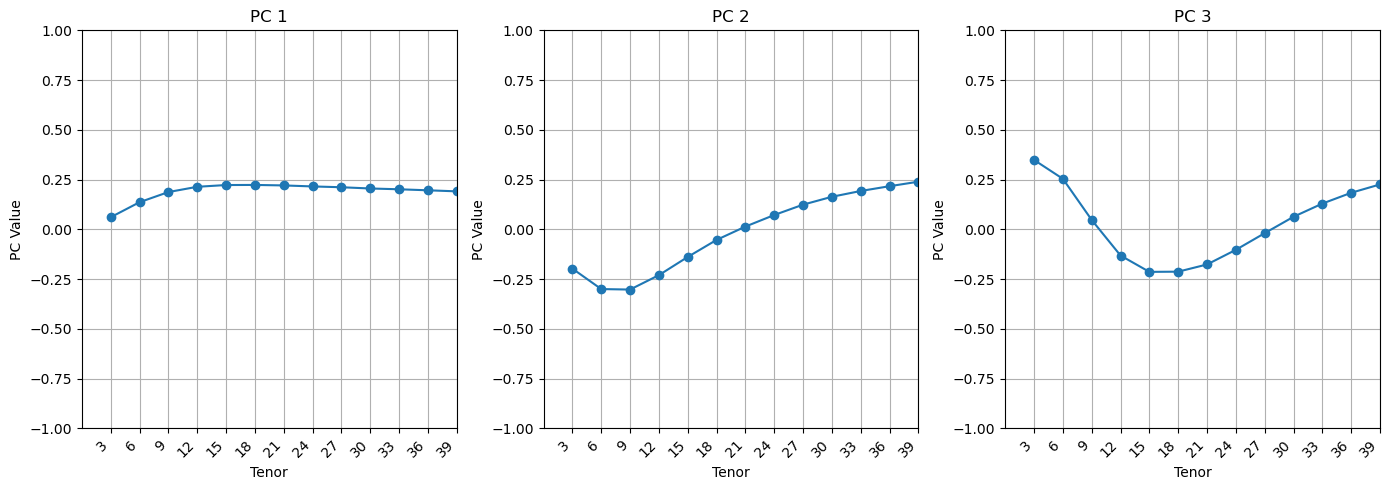

In [145]:
lambd, E = pca_port(portfolio, Q)
num_columns = E.shape[1]  
tenors = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]

plt.figure(figsize=(14, 5))

for i in range(num_columns):
    plt.subplot(1, 3, i + 1)
    plt.plot(tenors, E[3:16, i], marker='o', linestyle='-')
    plt.title(f'PC {i + 1}')
    plt.xlabel('Tenor')
    plt.ylabel('PC Value')
    plt.xticks(
        ticks=tenors,
        labels=[f'{month}' for month in tenors],
        rotation=45,  
        ha='right'    
    )
    plt.xlim(0, 39)
    plt.ylim(-1, 1)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [146]:
tgt_irs = IRS(
    effective=dt(2025, 3, 21), 
    termination="1y",
    spec="usd_irs",
    curves=curve_irs,
    notional=-1e6, 
)

In [147]:
tgt_irs.analytic_delta(curve=curve_irs)

<Dual: -97.864860, (irs0, irs1, irs2, ...), [-0.0, -0.0, -0.0, ...]>

In [148]:
def tgt_notional(tgt_delta):
        sensitivity_factor = tgt_irs.analytic_delta(curve=curve_irs).real / -1e6
        return tgt_delta / sensitivity_factor

tgt_notional(-22478)

-229684077.33981413

In [149]:
hedge_instruments = [
    IRS(dt(2025, 3, 21), "6M", spec="usd_irs", notional=-178280134, curves="irs"),
    IRS(dt(2025, 3, 21), "1Y", spec="usd_irs", notional=-229684076, curves="irs"),
    IRS(dt(2025, 3, 21), "2Y", spec="usd_irs", notional=13498607, curves="irs"),
]

In [150]:
for instrument in hedge_instruments:
    print(float(instrument.rate(solver=solver_irs)))

4.2212079345732025
4.044262929844003
3.798032258018541


In [151]:
portfolio.instruments.extend(hedge_instruments)

In [152]:
S_xpar = np.matmul(solver_fwd.jacobian(solver_par), portfolio.delta(solver=solver_fwd).to_numpy())
S_simple_par = S_xpar.droplevel(0)              
S_vec_par = np.asarray(S_simple_par, float).reshape(-1,1)

In [153]:
portfolio.delta(solver=solver_full).style.format("{:,.2f}")

In [154]:
S_xpar.style.format("{:,.2f}")

In [155]:
S_xpar.sum()

0    629.782798
dtype: float64

In [156]:
portfolio.npv(curves=curve_irs)

C:\Users\rtp09\anaconda3\envs\my_quant_lab\lib\site-packages\rateslib\instruments\generics.py:681: UserWarning: No ``base`` currency is inferred, using ``local`` output. To return a single PV specify a ``base`` currency and ensure an ``fx`` or ``solver.fx`` object is available to perform the conversion if the currency differs from the local.
  warnings.warn(


{'usd': <Dual: -0.000000, (irs0, irs1, irs2, ...), [71660722.9, 3803997.3, 6396521.9, ...]>}

In [157]:
portfolio.gamma(solver=solver_par).sum().sum()

0.1825241986125926

In [158]:
display(var_dataframe(Q_par, Q_mod, covar))
display(Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc))
display(Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc))
display(PCA_dataframe(pca_risk, covar, pca_covar_alloc))
display(mmt_dataframe(covar, covar_mmt, covar_mmt_impact))

,VaR
c,"2,108"
VaR 5%,"-3,467"
VaR 1%,"-4,903"
c mod,"2,108"


,S par,S_trade,c_impact,%,VaR alloc
1H5,0,-713,-29,-1,0
1J5,0,-267,-29,-1,0
1K5,0,-83,-7,-0,0
H5,0,-81,-12,-1,0
M5,0,26,-4,-0,0
U5,0,9,-1,-0,0
Z5,0,-6,-0,-0,0
H6,0,-9,-1,-0,0
M6,0,-4,-0,-0,0
U6,0,3,-0,-0,0


,S mod,S_trade,c_impact,%,VaR alloc
1H5,0,-713,-29,-1,0
1J5,0,-267,-29,-1,0
1K5,0,-83,-7,-0,0
H5,0,-81,-12,-1,0
M5,0,26,-4,-0,0
U5,0,9,-1,-0,0
Z5,0,-6,-0,-0,0
H6,0,-9,-1,-0,0
M6,0,-4,-0,-0,0
U6,0,3,-0,-0,0


,Sfwd,c,Percentage
PC1,-3,3,0
PC2,-40,49,2
PC3,-139,105,5


,"(19, 23, 27)","(17, 19, 23)"
1H5,0,0
1J5,0,0
1K5,0,0
H5,0,0
M5,0,0
U5,0,0
Z5,0,0
H6,0,0
M6,0,0
U6,0,0


In [159]:
translated_curve_irs = curve_irs.translate(dt(2025, 3, 20))

In [160]:
curve_irs.nodes.values

[<Dual: 1.000000, (irs0, irs1, irs2, ...), [1.0, 0.0, 0.0, ...]>,
 <Dual: 0.998560, (irs0, irs1, irs2, ...), [0.0, 1.0, 0.0, ...]>,
 <Dual: 0.998439, (irs0, irs1, irs2, ...), [0.0, 0.0, 1.0, ...]>,
 <Dual: 0.994024, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.988990, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.987854, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.987739, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.984338, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.978958, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.977683, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.977576, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.974501, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.970196, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.968199, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.967997, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.

In [161]:
translated_curve_irs.nodes.values

[<Dual: 1.000000, (1ca360), [1.0]>,
 <Dual: 0.998680, (irs0, irs1, irs2, ...), [-0.9, 0.9, 0.0, ...]>,
 <Dual: 0.998559, (irs0, irs1, irs2, ...), [-0.9, -0.1, 1.0, ...]>,
 <Dual: 0.994143, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.989109, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.987972, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.987857, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.984456, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.979076, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.977801, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.977693, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.974618, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.970312, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.968315, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.968113, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.965

In [162]:
translated_curve_irs_json = translated_curve_irs.to_json()  

from pathlib import Path
Path("translated_curve_irs.json").write_text(translated_curve_irs_json, encoding="utf-8")

2461

In [163]:
translated_curve_sofr = curve_sofr.translate(dt(2025, 3, 20))

In [164]:
translated_curve_sofr_json = translated_curve_sofr.to_json()  

Path("translated_curve_sofr.json").write_text(translated_curve_sofr_json, encoding="utf-8")

1173